In [1]:
import numpy as np
import pandas as pd
import math
import sklearn
import sklearn.preprocessing
import datetime
import os
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from sklearn.model_selection import train_test_split

In [2]:
dateparse = lambda dates: pd.datetime.strptime(dates, '%b %d, %Y')
# loading data for Argentina
argentina_stock = pd.read_csv('data/argentina.csv',sep=',', parse_dates=['Date'], date_parser=dateparse).fillna(0)
argentina_stock['Vol.'] = (argentina_stock['Vol.'].replace(r'[KM]+$', '', regex=True).astype(float) * argentina_stock['Vol.'].str.extract(r'[\d\.]+([KM]+)', expand=False).fillna(1).replace(['K','M'], [10**3, 10**6]).astype(int))
argentina_stock

/var/folders/tc/qfc76dxj7456z8tqv6mk4xfh0000gn/T/ipykernel_91133/1820159528.py:1: FutureWarning: The pandas.datetime class is deprecated and will be removed from pandas in a future version. Import from datetime module instead.
  dateparse = lambda dates: pd.datetime.strptime(dates, '%b %d, %Y')


,Date,Price,Open,High,Low,Vol.,Change %
0,2021-03-31,85.15,86.50,88.10,85.15,564300.0,-1.10%
1,2021-03-30,86.10,85.15,86.75,84.60,141400.0,1.29%
2,2021-03-29,85.00,80.00,86.00,79.00,371220.0,3.85%
3,2021-03-26,81.85,84.00,84.60,80.70,462550.0,-2.09%
4,2021-03-25,83.60,85.20,87.30,82.10,389780.0,-3.13%
...,...,...,...,...,...,...,...
295,2020-01-08,46.50,47.50,47.50,46.00,1180000.0,-2.31%
296,2020-01-07,47.60,48.35,49.00,46.90,901950.0,-1.86%
297,2020-01-06,48.50,48.40,48.70,47.00,719240.0,-0.61%
298,2020-01-03,48.80,48.25,49.45,46.50,595360.0,1.14%


In [66]:
# function to normalize values to feed to RNN
def normalize_data(df):
    min_max_scaler = sklearn.preprocessing.MinMaxScaler()
    df['Open'] = min_max_scaler.fit_transform(df.Open.values.reshape(-1,1))
    df['High'] = min_max_scaler.fit_transform(df.High.values.reshape(-1,1))
    df['Low'] = min_max_scaler.fit_transform(df.Low.values.reshape(-1,1))
    df['Price'] = min_max_scaler.fit_transform(df.Price.values.reshape(-1,1))
    return df

In [67]:
normalized_stock = normalize_data(argentina_stock)

In [68]:
normalized_stock

,Date,Price,Open,High,Low,Vol.,Change %
0,2021-03-31,0.932916,0.956140,0.964717,0.969891,564300.0,-1.10%
1,2021-03-30,0.949911,0.932456,0.939647,0.959854,141400.0,1.29%
2,2021-03-29,0.930233,0.842105,0.925720,0.857664,371220.0,3.85%
3,2021-03-26,0.873882,0.912281,0.899721,0.888686,462550.0,-2.09%
4,2021-03-25,0.905188,0.933333,0.949861,0.914234,389780.0,-3.13%
...,...,...,...,...,...,...,...
295,2020-01-08,0.241503,0.271930,0.210771,0.255474,1180000.0,-2.31%
296,2020-01-07,0.261181,0.286842,0.238626,0.271898,901950.0,-1.86%
297,2020-01-06,0.277281,0.287719,0.233055,0.273723,719240.0,-0.61%
298,2020-01-03,0.282648,0.285088,0.246982,0.264599,595360.0,1.14%


In [69]:
# Spliting data between test and the remaining. Test needs to be in between 1st Jab 2021 till 31st March 2021
start_date = '2021-01-01' 
end_date = '2021-03-31'
test = normalized_stock.loc[(normalized_stock['Date'] >= start_date) & (normalized_stock['Date'] <= end_date)]
remaining = normalized_stock[~normalized_stock.index.isin(test.index)]

In [70]:
# Spliting rest of the data between validation and training. Validation needs to be in between 1st Dec 2020 till 31st Dec 2020
val_start_date = '2020-12-01' 
val_end_date = '2020-12-30'
val_data = remaining.loc[(remaining['Date'] >= val_start_date) & (remaining['Date'] <= val_end_date)]
train = remaining[~remaining.index.isin(val_data.index)]

In [71]:
train

,Date,Price,Open,High,Low,Vol.,Change %
78,2020-11-30,0.922182,0.901754,0.903435,0.928832,635240.0,1.62%
79,2020-11-27,0.898032,0.905263,0.896936,0.895985,363950.0,0.00%
80,2020-11-26,0.898032,0.896491,0.907149,0.903285,106380.0,0.24%
81,2020-11-25,0.894454,0.903509,0.907149,0.927007,621150.0,-0.60%
82,2020-11-24,0.903399,0.859649,0.907149,0.894161,1220000.0,4.97%
...,...,...,...,...,...,...,...
295,2020-01-08,0.241503,0.271930,0.210771,0.255474,1180000.0,-2.31%
296,2020-01-07,0.261181,0.286842,0.238626,0.271898,901950.0,-1.86%
297,2020-01-06,0.277281,0.287719,0.233055,0.273723,719240.0,-0.61%
298,2020-01-03,0.282648,0.285088,0.246982,0.264599,595360.0,1.14%


In [76]:
# Making Date as the index for time series problem. 
x_train = train[['Date','Price','Open','High','Low']]
x_train['Date'] = pd.to_datetime(train['Date'])
x_train.set_index('Date', inplace=True)

/var/folders/tc/qfc76dxj7456z8tqv6mk4xfh0000gn/T/ipykernel_91133/2699296087.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  x_train['Date'] = pd.to_datetime(train['Date'])


In [77]:
# Making Date as the index for time series problem. 
val_train = val_data[['Date','Price','Open','High','Low']]
val_train['Date'] = pd.to_datetime(val_data['Date'])
val_train.set_index('Date', inplace=True)

/var/folders/tc/qfc76dxj7456z8tqv6mk4xfh0000gn/T/ipykernel_91133/3428657283.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  val_train['Date'] = pd.to_datetime(val_data['Date'])


In [78]:
# Making Date as the index for time series problem. 
y_test = test[['Date','Price','Open','High','Low']]
y_test['Date'] = pd.to_datetime(y_test['Date'])
y_test.set_index('Date', inplace=True)

/var/folders/tc/qfc76dxj7456z8tqv6mk4xfh0000gn/T/ipykernel_91133/2727257743.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  y_test['Date'] = pd.to_datetime(y_test['Date'])


In [79]:
# For training, we're only interested in the Open, High, and Low columns. 
X_train = x_train[['Open','High','Low']]
Y_train = x_train['Price']
X_val = val_train[['Open','High','Low']]
Y_val = val_train['Price']
X_test = y_test[['Open','High','Low']]
Y_test = y_test['Price']

In [80]:
print('X_train.shape = ',X_train.shape)
print('X_val.shape = ',X_val.shape)
print('X_test.shape = ',X_test.shape)
print('X_test.shape = ',Y_test.shape)

X_train.shape =  (222, 3)
X_val.shape =  (18, 3)
X_test.shape =  (60, 3)
X_test.shape =  (60,)


In [81]:
# Reshape the input data for the LSTM model
X_train = np.array(X_train)
X_val = np.array(X_val)
X_test = np.array(X_test)
X_train = X_train.reshape((X_train.shape[0], X_train.shape[1], 1))
X_val = X_val.reshape((X_val.shape[0], X_val.shape[1], 1))
X_test = X_test.reshape((X_test.shape[0], X_test.shape[1], 1))

In [36]:
# Define the model
model = keras.Sequential()
model.add(layers.GRU(64, input_shape=(3, 1), return_sequences=True))
model.add(layers.LSTM(64, return_sequences=True))
model.add(layers.Dropout(0.2))
model.add(layers.LSTM(32, return_sequences=False))
model.add(layers.Dense(1))

# Compile the model
model.compile(optimizer='adam', loss='mean_absolute_error')

In [37]:
# Train the model
history = model.fit(X_train, Y_train, epochs=50, batch_size=16, validation_data=(X_val, Y_val))

Epoch 1/50
14/14 [==============================] - 2s 23ms/step - loss: 0.2861 - val_loss: 0.4343
Epoch 2/50
14/14 [==============================] - 0s 4ms/step - loss: 0.1168 - val_loss: 0.2271
Epoch 3/50
14/14 [==============================] - 0s 3ms/step - loss: 0.0758 - val_loss: 0.0307
Epoch 4/50
14/14 [==============================] - 0s 3ms/step - loss: 0.0382 - val_loss: 0.0742
Epoch 5/50
14/14 [==============================] - 0s 3ms/step - loss: 0.0430 - val_loss: 0.0276
Epoch 6/50
14/14 [==============================] - 0s 3ms/step - loss: 0.0351 - val_loss: 0.0393
Epoch 7/50
14/14 [==============================] - 0s 3ms/step - loss: 0.0362 - val_loss: 0.0282
Epoch 8/50
14/14 [==============================] - 0s 3ms/step - loss: 0.0294 - val_loss: 0.0279
Epoch 9/50
14/14 [==============================] - 0s 3ms/step - loss: 0.0264 - val_loss: 0.0388
Epoch 10/50
14/14 [==============================] - 0s 3ms/step - loss: 0.0255 - val_loss: 0.0296
Epoch 11/50
14/14 

In [47]:
# Evaluate the model on the test set
mae = model.evaluate(X_test[:1], Y_test[:1])
print('Test MAE:', mae)

1/1 [==============================] - 0s 11ms/step - loss: 0.0207
Test MAE: 0.020667076110839844


# MAE for 7, 30, and 1 day

30 days: 0.024
7 days: 0.028
1 day: 0.020

In [118]:
predicted_range = X_test[:7]
predicted_values = model.predict(predicted_range)
# predicted_range[0][0]
difference = predicted_values - predicted_range[0][0]

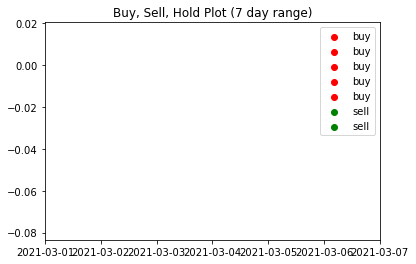

In [119]:
date_range = 7  # in days

# Calculate start and end dates based on the date range
end_date = datetime.date(2021,3,7)
start_date = datetime.date(2021,3,1)

# Create a figure and axis object
fig, ax = plt.subplots()

# Loop through the values to determine the label and color for each point
for i, value in enumerate(difference):
    if value < 0:
        label = 'buy'
        color = 'red'
    elif value > 0:
        label = 'sell'
        color = 'green'
    else:
        label = 'hold'
        color = 'blue'
        
    # Calculate the date for the point based on its position in the values array
    date = end_date - datetime.timedelta(days=len(test['Date'])-i-1)
    
    # Plot the point with the determined label, color, and date
    ax.scatter(date, value, label=label, color=color)

# Add legend and title to the plot
ax.legend()
ax.set_title(f'Buy, Sell, Hold Plot ({date_range} day range)')

# Set the x-axis limits to the date range
ax.set_xlim(start_date, end_date)

# Show the plot
plt.show()

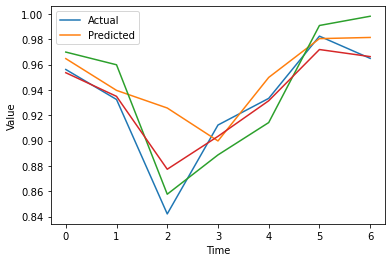

In [120]:
# plt.plot(X_test[:, :, 0])
plt.plot(predicted_range[:, :, 0])
# Plot the predicted values
plt.plot(predicted_values)

# Add legend and axis labels
plt.legend(['Actual', 'Predicted'])
plt.xlabel('Time')
plt.ylabel('Value')
plt.show()